<a href="https://colab.research.google.com/github/marinwitherspoon/Image_Description_Application/blob/Marin-Witherspoon/huggingface.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Logging into Hugging Face Notebook CLI

In [1]:
pip install -U "huggingface_hub[cli]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 3.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
from huggingface_hub import login
login()

In [2]:
# Getting the required libraries
import json
from pathlib import Path
import os
import shutil
import pandas as pd
import random

In [4]:
# Installing required libraries
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q datasets

### Preprocessing the Dataset for finetuning

Images

if below dataset structure is required. Use the code snippet below.

In [5]:
def create_dataset_structure(source_folder, dest_folder, split_percent):
    """
    input: Takes the images folder where all our captions images are kept
    source_folder : folder where all the images are located
    dest_folder : where our output repository should be stored
    split_percent: amount of split required for training-testing
    output: Appropriately makes the file structure according to huggingface
            my_dataset_repository
                            ├── folder/train/image1.png
                            ├── folder/train/image2.png
                            ├── folder/train/image3.png
                            ├── folder/test/image4.png
                            └── folder/train/metadata.jsonl
    """
    ## creating testing and training folders in the destination folder
    train_folder = os.path.join(dest_folder, 'train')
    test_folder = os.path.join(dest_folder, 'test')

    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(test_folder, exist_ok = True)

    # getting the list of images in source folder
    image_files = [f for f in os.listdir(source_folder) if f.endswith(('.jpg', '.jpeg','.png', '.gif'))]

    # Calculate the number of images for train and test based on split
    num_train = int(len(image_files)* 0.80)
    num_test =  int(len(image_files) * (1 - split_percent))

    # randomly shuffling images
    random.shuffle(image_files)

    # copying images to train folder
    for image_file in image_files[:num_train]:
        source_path = os.path.join(source_folder, image_file)
        dest_path = os.path.join(train_folder, image_file)
        shutil.copy(source_path, dest_path)

    # copying images to test folder
    for image_file in image_files[num_train:]:
        source_path = os.path.join(source_folder, image_file)
        dest_path = os.path.join(test_folder, image_file)
        shutil.copy(source_path, dest_path)


In [7]:
source_folder = r"/Users/ours/Desktop/Image Description Capstone/Flickr 8k/Images/"
dest_folder = r"/Users/ours/Desktop/Image Description Capstone/Image_Description_Application"
split_percent = 0.80
create_dataset_structure(source_folder, dest_folder, split_percent )

In [8]:
#### checking if there are images lost while doing preprocessing
len(os.listdir(source_folder))

x = os.path.join(dest_folder, 'test')
y =os.path.join(dest_folder, 'train')
len(os.listdir(x)) + len(os.listdir(y))

8091

Captions -  4 captions are randomly dropped for each image.

In [10]:
def hugging_face_model_format(source_folder, dest_folder):
    """
    input: Takes the processed captions file
    source_folder: This is where our processed captions will be stored
    dest_folder: This is where our images (train/test) are saved.

    output: Creates a output JSON File that is required by for the huggingface input model
           eg :  [{ "file_name" : "image.name" , "text" : "description of the text"} , ...
    """

    ## getting the processed captions
    with open(source_folder , 'r') as f:
        data = json.load(f)

    ## this model requires a  list of captions where each image is in {} format shown above in docstring
    random_captions = []
    for k , (image,caption) in data.items():
        random_captions.append({"file_name" : str(image) , "text": str(caption)})

    df = pd.DataFrame(random_captions)
    df_unique = df.sample(frac=1).drop_duplicates(subset='file_name').reset_index(drop=True)

    random_captions = df_unique.to_dict(orient='records')

    with open(os.path.join(dest_folder, 'metadata.jsonl'), 'w') as f:
        for item in random_captions:
            f.write(json.dumps(item) + '\n')
    return random_captions


source_folder  = r"/Users/ours/Desktop/Image Description Capstone/Image_Description_Application/data_structure/data_captions_processed.json"
dest_folder = r"/Users/ours/Desktop/Image Description Capstone/Image_Description_Application/data_structure/"
captions = hugging_face_model_format(source_folder, dest_folder)

In [11]:
with open(source_folder, 'r') as f:
    data = json.load(f)

len(data)
len(captions)*5

40455

### Loading the Dataset


checking if our pre-processing images and captions worked or not

In [4]:
from datasets import load_dataset

dataset_path = r"/Users/ours/Desktop/Image Description Capstone/Image_Description_Application/all_data"
dataset = load_dataset(dataset_path)

Resolving data files:   0%|          | 0/6473 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1620 [00:00<?, ?it/s]

In [5]:
dataset['train'], dataset['test']

(Dataset({
     features: ['image', 'text'],
     num_rows: 6472
 }),
 Dataset({
     features: ['image', 'text'],
     num_rows: 1619
 }))

In [6]:
train_dataset = dataset['train']
test_dataset = dataset['test']

Visualizing couple of samples

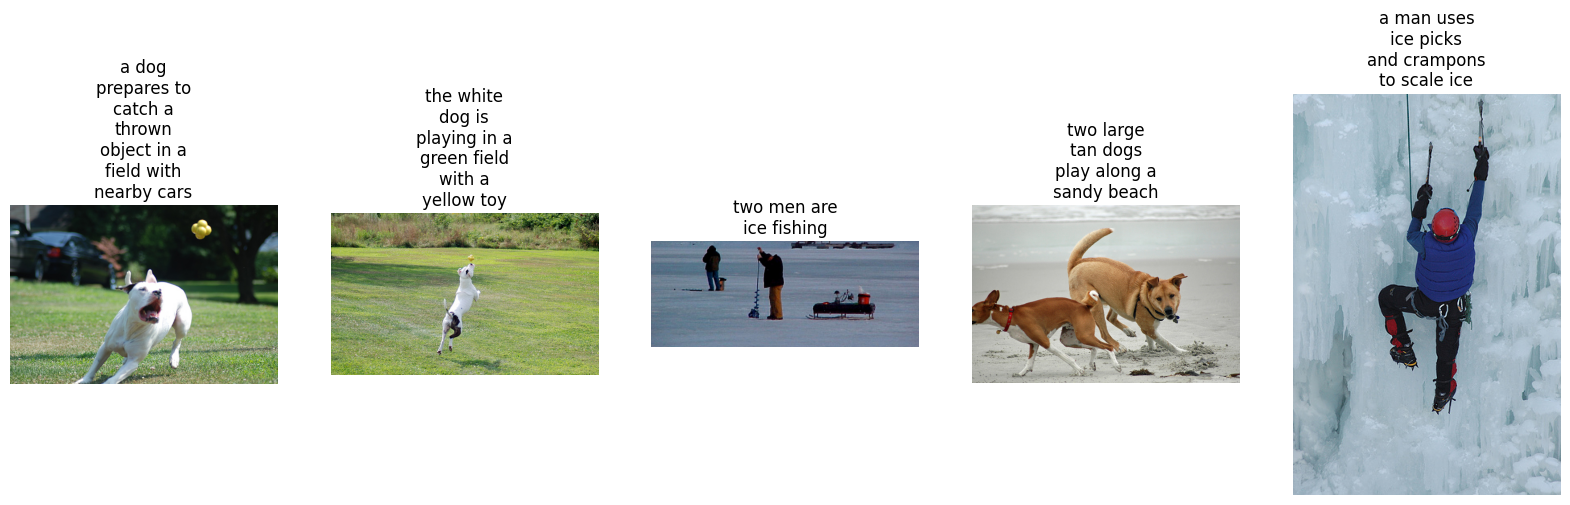

In [7]:
from textwrap import wrap
import matplotlib.pyplot as plt
import numpy as np


def plot_images(images, captions):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        caption = captions[i]
        caption = "\n".join(wrap(caption, 12))
        plt.title(caption)
        plt.imshow(images[i])
        plt.axis("off")


sample_images_to_visualize = [np.array(train_dataset[i]["image"]) for i in range(10,15)]
sample_captions = [train_dataset[i]["text"] for i in range(10,15)]
plot_images(sample_images_to_visualize, sample_captions)